In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.style.use('seaborn-darkgrid')

In [2]:
x = pd.read_csv('GLD.csv',index_col = 0)['Close']
y = pd.read_csv('GDX.csv',index_col = 0)['Close']
z = pd.read_csv('USO.csv',index_col = 0)['Close'] 

In [3]:
df = pd.concat([x,y,z],axis = "columns")

In [4]:
df.columns = ["GDX","GLD","USO"]

In [5]:
df.index = pd.to_datetime(df.index)

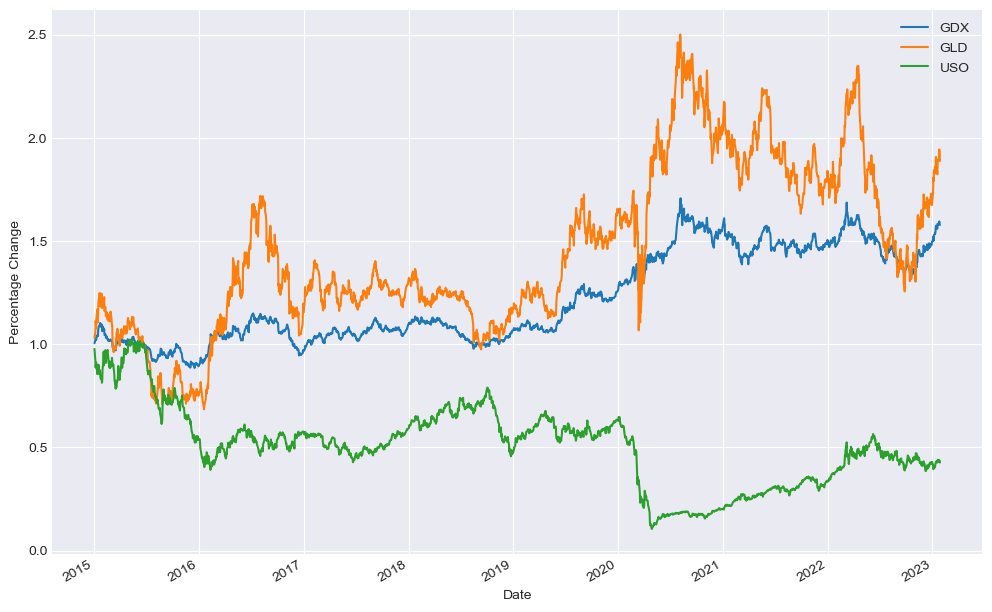

In [6]:
(df.pct_change()+1).cumprod().plot(figsize = (12,8))
plt.ylabel('Percentage Change')
plt.show()

In [7]:
from statsmodels.api import OLS
model = OLS(df['GLD'].iloc[:90], df[['GDX', 'USO']].iloc[:90])
model = model.fit()
print('The hedge ratio for GDX and USO are')
model.params

The hedge ratio for GDX and USO are


GDX    0.16880
USO   -0.00552
dtype: float64

In [8]:
m1 = model.params[0]
m2 = model.params[1]

In [9]:
df['spread'] = df["GLD"] - m1 * df["GDX"] - m2 * df["USO"]

The spread is: GLD - 0.168800 * GDX - -0.005520 * USO


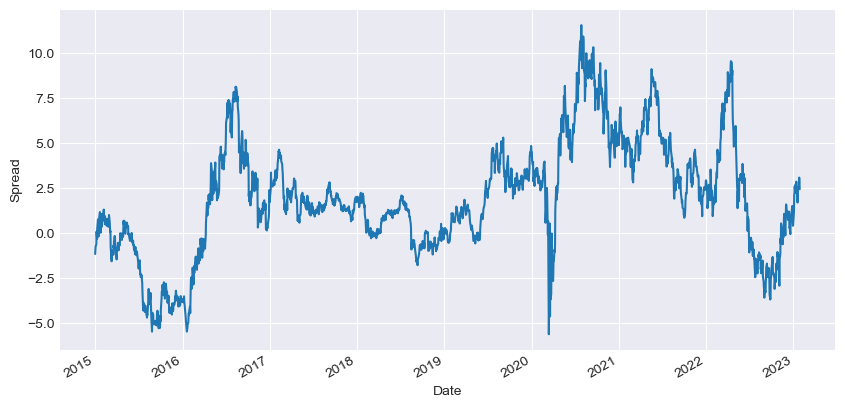

In [10]:
print('The spread is: GLD - %f * GDX - %f * USO' %
      (model.params[0], model.params[1]))

df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df.spread, maxlag=1)
adf[0]

-3.1359260355752765

In [12]:
adf[4]

{'1%': -3.4335738228216677,
 '5%': -2.8629641232861176,
 '10%': -2.5675281403557513}

In [13]:
critical_value = adf[4]['10%'] 

t_stat = adf[0]

# Compare t-statistic with critical value
cointegrated = t_stat < critical_value

# set result to True if cointegrated, else False
is_triplet_cointegrated = True if cointegrated else False 

f"The triplet is cointegrated: {is_triplet_cointegrated}"

'The triplet is cointegrated: True'

In [14]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

In [15]:
df = stat_arb(df, 15, 1)

In [16]:
df.head(3)

,GDX,GLD,USO,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions,spread_difference,pnl,cumpnl
Date,,,,,,,,,,,,,,,,,,
2014-12-31,113.580002,17.118013,162.880005,-1.155174,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN
2015-01-02,114.080002,17.639563,159.119995,-0.738780,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN,0.416393,NaN,NaN
2015-01-05,115.800003,18.105232,150.320007,-0.612024,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,NaN,0.126756,NaN,NaN


Text(0.5, 1.0, 'CUMPNL')

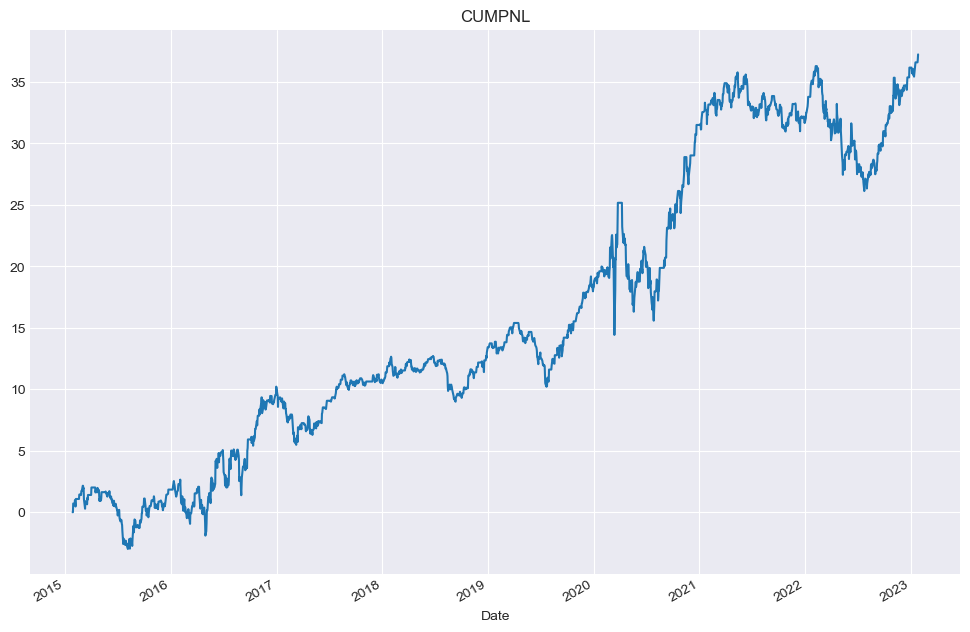

In [17]:
df['cumpnl'].plot(figsize=(12,8))
plt.title("CUMPNL")